In [52]:
from clearml.backend_api.session.client import APIClient
from clearml import Task
import pickle
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create an instance of APIClient
client = APIClient()

In [53]:
project_list = []
page = 0
while True:
    new_projects = client.projects.get_all(page = page)
    if len(new_projects) == 0:
        break
    project_list += new_projects
    page += 1
project_names = [project.name for project in project_list]

In [68]:
from datetime import datetime, timezone
task_list = []
page = 0
days = 77
now = datetime.now(timezone.utc)
while True:
    new_tasks = client.tasks.get_all(page = page, page_size=300, order_by=['-created'])
    if len(new_tasks) == 0:
        break
    task_list += new_tasks
    page += 1
    current_day = (now - pd.to_datetime(Task.get_task(new_tasks[-1].id).data.created)).days
    print(f"Current day: {current_day}, current page: {page}")
    if(current_day > days):
        break

Current day: 5, current page: 1
Current day: 10, current page: 2
Current day: 22, current page: 3
Current day: 30, current page: 4
Current day: 35, current page: 5
Current day: 47, current page: 6
Current day: 54, current page: 7
Current day: 64, current page: 8
Current day: 72, current page: 9
Current day: 84, current page: 10


In [78]:
if(os.path.exists("tasks.pkl")):
    with open ("tasks.pkl", "rb") as f:
        tasks = pickle.load(f)
else:
    tasks: dict[str,dict] = {}
new_tasks = [task for task in task_list if task.id not in tasks]
num_of_tasks = len(new_tasks)
cur_task_num = 0
step = 10
while cur_task_num < num_of_tasks:
    cur_tasks = Task.get_tasks([t.id for t in new_tasks[cur_task_num:cur_task_num+step]])
    if(len(cur_tasks) == 0):
        print("what's wrong?")
        break
    for task in cur_tasks:
        data = task.data.to_dict()
        try:
            script = data["script"]["diff"][:-11]
            args = script.split("args = ")
            data["script_args"] = json.loads(args[1].replace("'", '"').replace('"""',"").replace("True","true").replace("False","false"))
        except:
            data["script_args"] = {}
        tasks[task.id] = data
    cur_task_num += step
    if(cur_task_num % 50 == 0):
        print(f"Processed {cur_task_num} out of {num_of_tasks} tasks")
with open ("tasks.pkl", "wb") as f:
    pickle.dump(tasks, f)

Processed 50 out of 2709 tasks
Processed 100 out of 2709 tasks
Processed 150 out of 2709 tasks
Processed 200 out of 2709 tasks
Processed 250 out of 2709 tasks
Processed 300 out of 2709 tasks
Processed 350 out of 2709 tasks
Processed 400 out of 2709 tasks
Processed 450 out of 2709 tasks
Processed 500 out of 2709 tasks
Processed 550 out of 2709 tasks
Processed 600 out of 2709 tasks
Processed 650 out of 2709 tasks
Processed 700 out of 2709 tasks
Processed 750 out of 2709 tasks
Processed 800 out of 2709 tasks
Processed 850 out of 2709 tasks
Processed 900 out of 2709 tasks
Processed 950 out of 2709 tasks
Processed 1000 out of 2709 tasks
Processed 1050 out of 2709 tasks
Processed 1100 out of 2709 tasks
Processed 1150 out of 2709 tasks
Processed 1200 out of 2709 tasks
Processed 1250 out of 2709 tasks
Processed 1300 out of 2709 tasks
Processed 1350 out of 2709 tasks
Processed 1400 out of 2709 tasks
Processed 1450 out of 2709 tasks
Processed 1500 out of 2709 tasks
Processed 1550 out of 2709 tas

In [79]:
if(os.path.exists("projects.pkl")):
    with open ("projects.pkl", "rb") as f:
        projects = pickle.load(f)
else:
    projects = {}
new_projects = [project for project in project_list if project.id not in projects]
for project in new_projects:
    projects[project.id] = {}
    projects[project.id]["name"] = project.name
    projects[project.id]["first_run"] = None
    projects[project.id]["last_run"] = None
    projects[project.id]["tasks"] = []
for id, task in tasks.items():
    if(task["project"] not in projects):
        projects[task["project"]] = {}
        projects[task["project"]]["name"] = "unknown"
        projects[task["project"]]["first_run"] = None
        projects[task["project"]]["last_run"] = None
        projects[task["project"]]["tasks"] = []
    if(id in projects[task["project"]]["tasks"]):
        continue
    if("started" in task):
        projects[task["project"]]["first_run"] = min(projects[task["project"]]["first_run"], task["started"]) if projects[task["project"]]["first_run"] else task["started"]
        projects[task["project"]]["last_run"] = max(projects[task["project"]]["last_run"], task["started"]) if projects[task["project"]]["last_run"] else task["started"]
    projects[task["project"]]["tasks"].append(task["id"])
with open ("projects.pkl", "wb") as f:
    pickle.dump(projects, f)

In [113]:
prod_name = "Machine/prod.serval-api.org"
#prod_name = "Machine"
projects_chosen = [project for project in projects if prod_name in projects[project]["name"]]
#tasks_chosen = [tasks[task] for task in tasks if tasks[task]["project"] in projects_chosen]
tasks_chosen = [tasks[task] for task in tasks]

<Axes: title={'center': 'Tasks started per week'}, xlabel='week'>

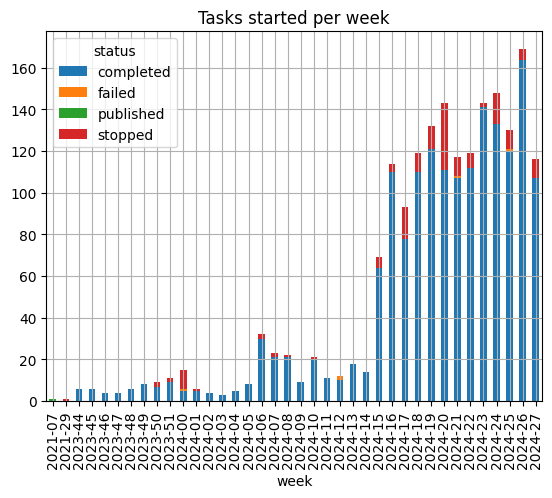

In [115]:
# graph the tasks started per day using pandas
tasks_df = pd.DataFrame.from_dict(tasks_chosen)
tasks_df.loc[:,"total_run_time"] = pd.to_timedelta(tasks_df["completed"] - tasks_df["started"]).dt.total_seconds()
mask = tasks_df["total_run_time"] > 600
#mask = tasks_df["total_run_time"] > -1
tasks_df["week"] = pd.to_datetime(tasks_df["started"]).dt.strftime('%Y-%U')
by_week = pd.crosstab(index=tasks_df.loc[mask,"week"], columns=tasks_df.loc[mask,"status"])
by_week.plot(kind="bar", stacked = True, title="Tasks started per week", grid=True)

array([[<Axes: title={'center': 'total_run_time'}>]], dtype=object)

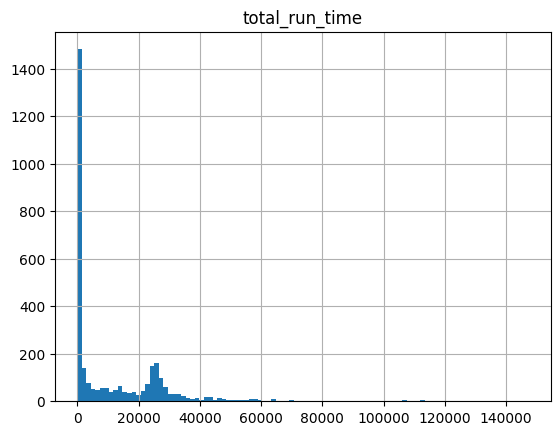

In [116]:
tasks_df.loc[:,"total_run_time"] = pd.to_timedelta(tasks_df["completed"] - tasks_df["started"]).dt.total_seconds()
tasks_df.hist(column="total_run_time",bins=100)

/tmp/ipykernel_992988/912108104.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(by_week.keys(), rotation=45)


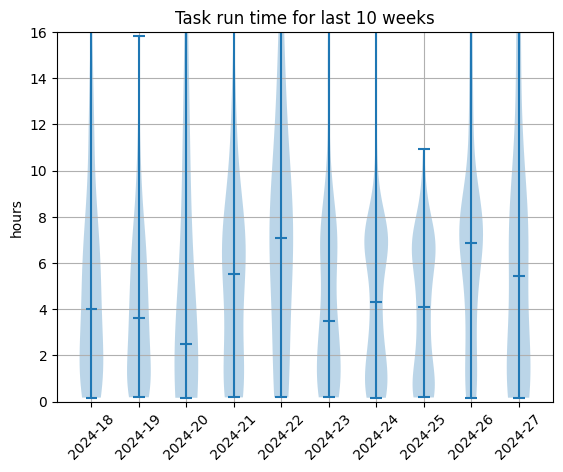

In [120]:
fig, axes = plt.subplots()
by_week = {week: tasks_df[tasks_df["week"] == week]["total_run_time"].to_numpy() for week in tasks_df["week"].unique()}
#filter out things under 10 minutes
by_week = {week: times[times > 600] / 60 / 60 for week, times in by_week.items() if len(times[times > 600]) > 1}
#last 10 weeks only
by_week = {week: by_week[week] for week in np.sort(list(by_week.keys()))[-10:]}
axes.violinplot(dataset = list(by_week.values()), showmedians=True)
axes.set_title("Task run time for last 10 weeks")
axes.set_xticklabels(by_week.keys(), rotation=45)
axes.set_xticks(range(1, len(by_week) + 1))
axes.set_ylabel("hours")
axes.set_ylim(0, 16)
axes.grid(True)

/tmp/ipykernel_992988/402610322.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(by_week.keys(), rotation=45)


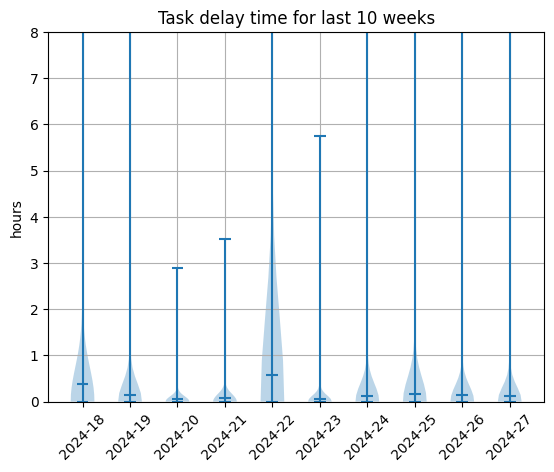

In [123]:
tasks_df.loc[:,"delay_time"] = pd.to_timedelta(tasks_df["started"] - tasks_df["created"]).dt.total_seconds()
fig, axes = plt.subplots()
by_week = {week: tasks_df[tasks_df["week"] == week]["delay_time"].to_numpy() for week in tasks_df["week"].unique()}
#filter out things under 10 minutes
by_week = {week: times / 60 / 60 for week, times in by_week.items() if len(times) > 1}
#last 10 weeks only
by_week = {week: by_week[week] for week in np.sort(list(by_week.keys()))[-10:]}
axes.violinplot(dataset = list(by_week.values()), showmeans=True)
axes.set_title("Task delay time for last 10 weeks")
axes.set_xticklabels(by_week.keys(), rotation=45)
axes.set_xticks(range(1, len(by_week) + 1))
axes.set_ylim(0, 8)
axes.set_ylabel("hours")
axes.grid(True)